In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [28]:
train = pd.read_csv("../dataset/original/train.csv")
test = pd.read_csv("../dataset/original/x_test.csv")

In [29]:
train.shape

(5719, 11)

In [30]:
test.shape

(300, 10)

In [34]:
def convert_date(df):
    df['Unnamed: 0'] = df['Unnamed: 0'].str.split(" ")
    df['Unnamed: 0'] = df['Unnamed: 0'].apply(lambda x: "-".join(x[1:]))
    df = df.rename(columns={'Unnamed: 0':'Date'})
    df.Date = pd.to_datetime(df.Date)
    return df

In [35]:
df = pd.concat([train, test])
df

,Unnamed: 0,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target
0,WE 10 December 2016,2689,SINGLE,395.41,BRAND1,1.16,NaN,NaN,NaN,0,24175.0
1,WE 17 December 2016,2689,SINGLE,395.41,BRAND1,1.15,1.0,17.676112,24175.0,0,23521.0
2,WE 24 December 2016,2689,SINGLE,395.41,BRAND1,1.16,1.0,24.482803,23521.0,0,22075.0
3,WE 31 December 2016,2689,SINGLE,395.41,BRAND1,1.16,0.0,19.410646,22075.0,0,16492.0
4,WE 07 January 2017,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0,25971.0
...,...,...,...,...,...,...,...,...,...,...,...
295,WE 16 November 2019,1206,SINGLE,125.65,BRAND4,0.41,19.0,98.800841,111353.0,1,NaN
296,WE 23 November 2019,1206,SINGLE,125.65,BRAND4,0.57,2.0,99.129248,63359.0,1,NaN
297,WE 30 November 2019,1206,SINGLE,125.65,BRAND4,0.57,0.0,28.696578,35238.0,1,NaN
298,WE 07 December 2019,1206,SINGLE,125.65,BRAND4,0.56,2.0,18.972899,34242.0,1,NaN


In [36]:
df = convert_date(df)

In [37]:
df = df.sort_values(['sku','Date'])

# Encoding Categorical Features

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.pack = le.fit_transform(df.pack)
le.classes_

array(['MULTI', 'SINGLE'], dtype=object)

In [39]:
df.brand = le.fit_transform(df.brand)
le.classes_

array(['BRAND1', 'BRAND2', 'BRAND3', 'BRAND4', 'BRAND5'], dtype=object)

In [40]:
test

,Unnamed: 0,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope
0,WE 29 June 2019,1027,SINGLE,114.23,BRAND2,0.56,10.0,24.386541,66337.0,1
1,WE 06 July 2019,1027,SINGLE,114.23,BRAND2,0.55,4.0,37.437842,49992.0,1
2,WE 13 July 2019,1027,SINGLE,114.23,BRAND2,0.45,0.0,28.039623,58062.0,1
3,WE 20 July 2019,1027,SINGLE,114.23,BRAND2,0.50,19.0,100.000000,90908.0,1
4,WE 27 July 2019,1027,SINGLE,114.23,BRAND2,0.42,26.0,99.191839,108957.0,1
...,...,...,...,...,...,...,...,...,...,...
295,WE 16 November 2019,1206,SINGLE,125.65,BRAND4,0.41,19.0,98.800841,111353.0,1
296,WE 23 November 2019,1206,SINGLE,125.65,BRAND4,0.57,2.0,99.129248,63359.0,1
297,WE 30 November 2019,1206,SINGLE,125.65,BRAND4,0.57,0.0,28.696578,35238.0,1
298,WE 07 December 2019,1206,SINGLE,125.65,BRAND4,0.56,2.0,18.972899,34242.0,1


In [41]:
df = df.astype({'pack':int, 'brand':int})

In [42]:
train = df[~df.target.isna()]
train.shape

(5719, 11)

In [43]:
test = df[df.target.isna()]
test.shape

(300, 11)

# Plot

In [44]:
train = train.reset_index()

In [45]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)

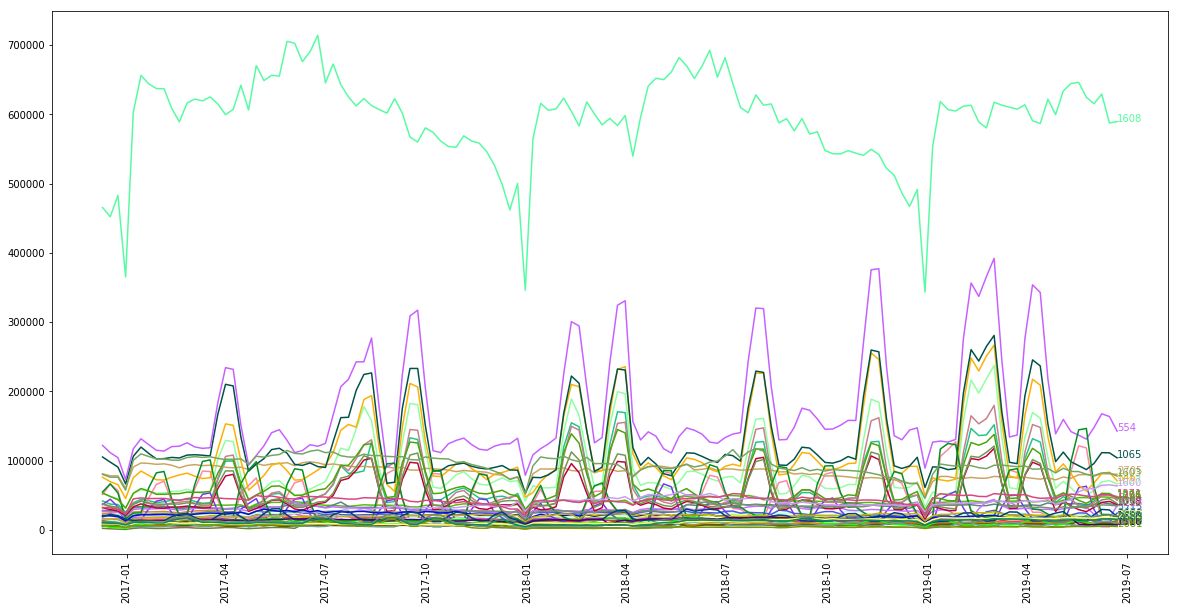

In [46]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(train.sku)):
    plt.plot(train[train.sku==s].Date, train[train.sku==s].target,  color=mycolors[i])
    last_x, last_y = train[train.sku==s].Date.values[-1], train[train.sku==s].target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

In [47]:
train = train.sort_values(['sku', 'Date'])
train = train.reset_index(drop=True)

# Peaks Analysis

## Extract peak indeces

In [102]:
def get_peaks(df, highest=True): 
    """
    La funzione get_min_significant_diff cerca di prendere quelle peak che sono realmente significative:
    guardo la differenza nel target tra monte e valle e si considerano tutti quei peaks che hanno una ampiezza maggiore
    di un certo delta, stabilito a seconda della time series
    
    return: (peak_value, peak_index, peak-valley)
    """
    peaks = []
    peak_idxs = []
    start_idx = df.index[0]
    end_idx = df.index[-1]
    i = start_idx 
    peak = df.loc[i, 'target']
    valley = df.loc[i, 'target']
    diff = []
    while(i < end_idx ):
        while(i < end_idx and df.loc[i, 'target'] >= df.loc[i+1, 'target']):
            i += 1
        valley = df.loc[i, 'target']
        while(i < end_idx and df.loc[i, 'target'] <= df.loc[i+1, 'target']):
            i += 1
        peak = df.loc[i, 'target']
        
        diff.append(peak-valley)
        peaks.append((peak, i, peak-valley))
    
    if highest==False:
        return [x[0] for x in peaks], [x[1] for x in peaks], [x[2] for x in peaks]
    
    
    diff = diff[:-1]    # alla fine peak - valley = 0, rimuoviamo l'ultimo valore
    def get_min_significant_diff(diff):
        diff = [(x, i) for i, x in enumerate(diff)]
        diff.sort(key=lambda x: x[0], reverse=True)
        residual = [diff[x][0] - diff[x+1][0] for x in range(len(diff)-1)]
        max_res_idx = np.argmax(residual)
        min_significant_diff = diff[max_res_idx][0]
        return min_significant_diff
    
    delta = get_min_significant_diff(diff)
    highest_peaks = [x for x in peaks if x[2] >= delta]
    
    # Create a list for each tuple element position
    pks = [x[0] for x in highest_peaks]
    idxs = [x[1] for x in highest_peaks]
    jumps = [x[2] for x in highest_peaks]

    return pks, idxs, jumps

## Check Frequencies of significant peaks

In [50]:
from collections import Counter

In [111]:
def get_common_peaks_day(highest=True):
    common_peak_days = []
    for s in tqdm(set(train.sku)):
        _, peak_idx, _ = get_peaks(train[train.sku==s], highest=highest)
        dt = list(train.loc[peak_idx].Date.values)
        common_peak_days.append(dt)
    common_peak_days = [x.astype(str).split('T')[0] for y in common_peak_days for x in y]
    return common_peak_days

In [112]:
common_peak_days = get_common_peaks_day()

<BarContainer object of 63 artists>

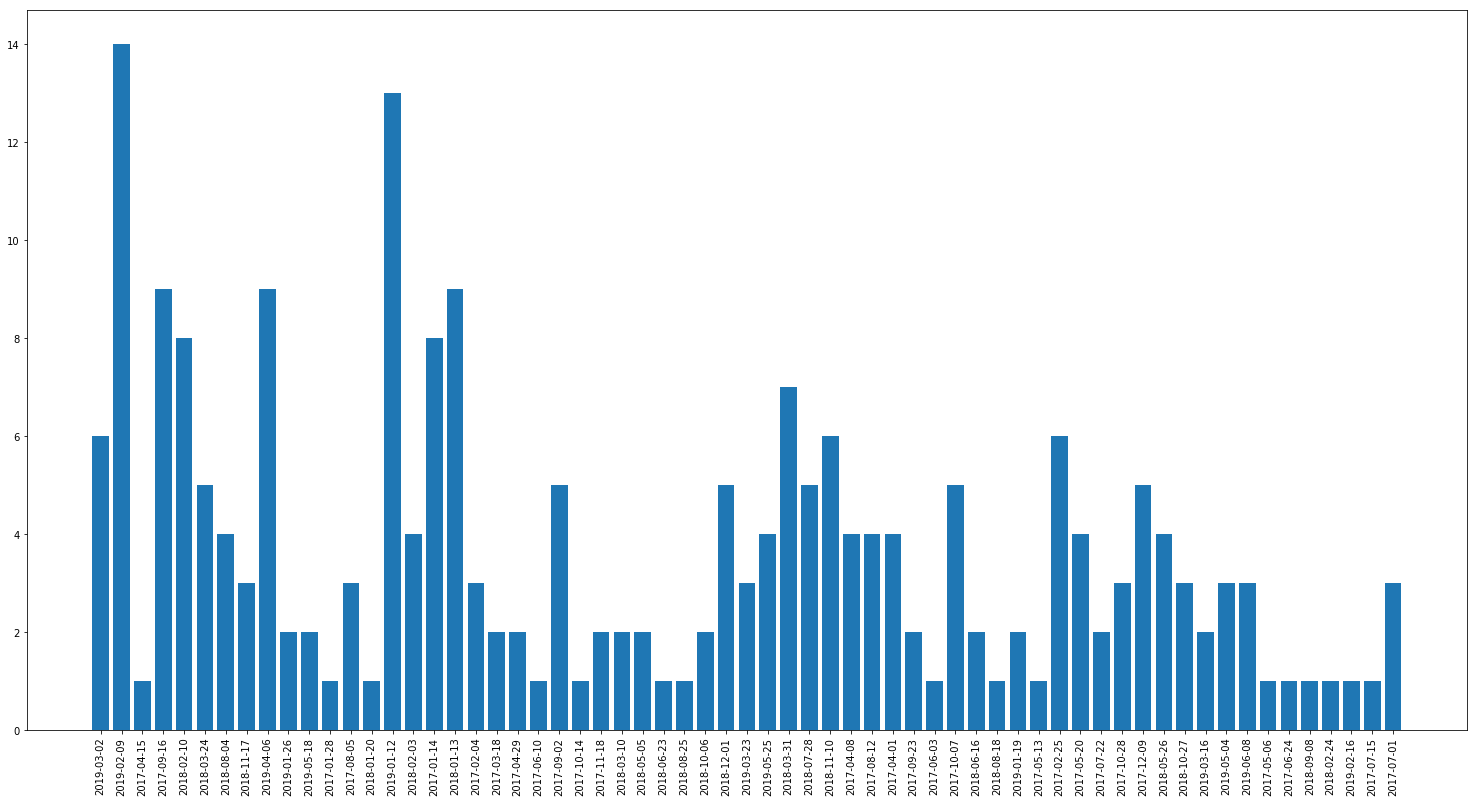

In [113]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation=90)
ax.bar(list(Counter(common_peak_days).keys()), list(Counter(common_peak_days).values()))

## Check Frequencies of all peaks

In [114]:
common_peak_days = get_common_peaks_day(highest=False)

<BarContainer object of 115 artists>

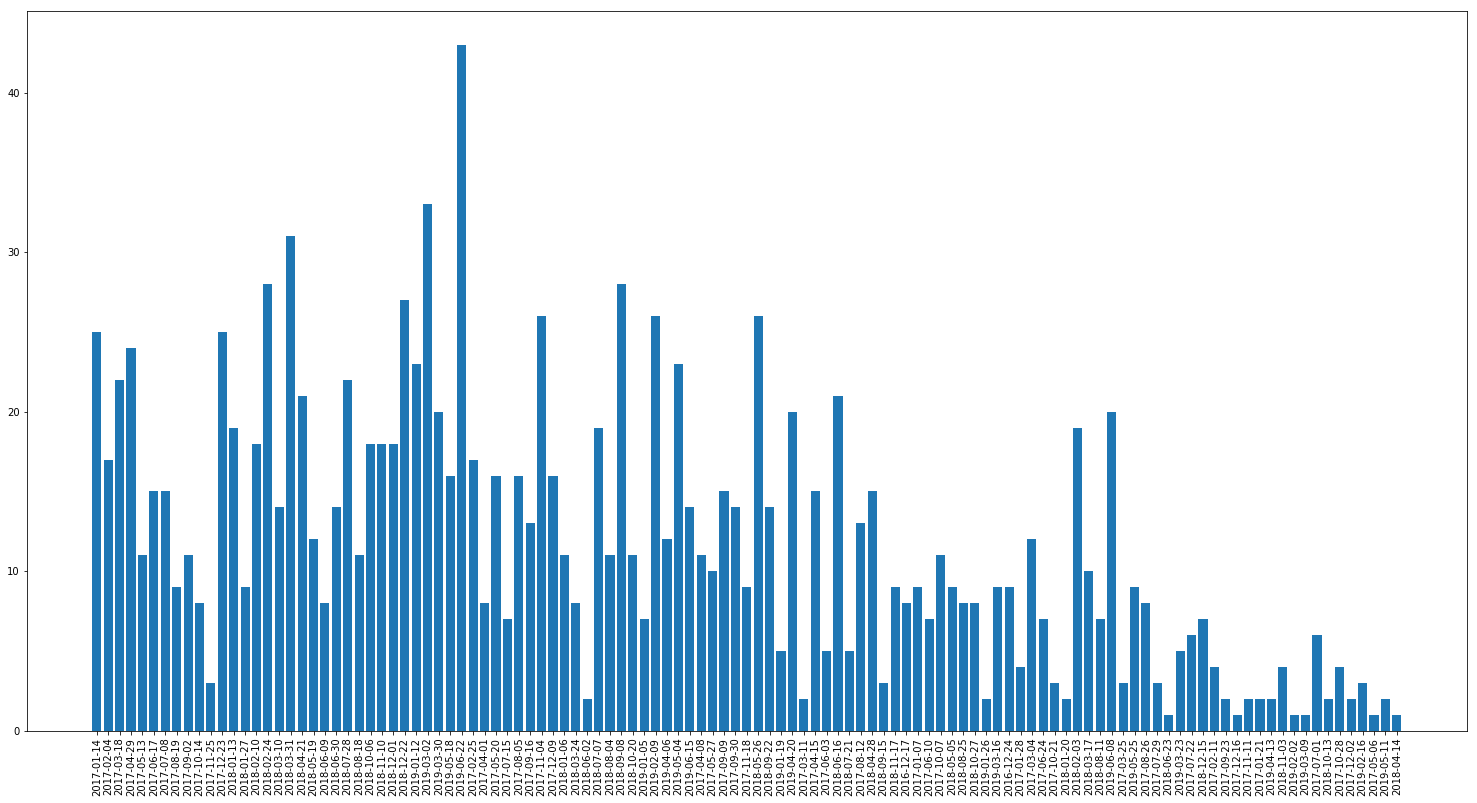

In [115]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation=90)
ax.bar(list(Counter(common_peak_days).keys()), list(Counter(common_peak_days).values()))

In [117]:
Counter(common_peak_days).most_common()

[('2019-06-22', 43),
 ('2019-03-02', 33),
 ('2018-03-31', 31),
 ('2018-02-24', 28),
 ('2018-09-08', 28),
 ('2018-12-22', 27),
 ('2017-11-04', 26),
 ('2019-02-09', 26),
 ('2018-05-26', 26),
 ('2017-01-14', 25),
 ('2017-12-23', 25),
 ('2017-04-29', 24),
 ('2019-01-12', 23),
 ('2019-05-04', 23),
 ('2017-03-18', 22),
 ('2018-07-28', 22),
 ('2018-04-21', 21),
 ('2018-06-16', 21),
 ('2019-03-30', 20),
 ('2019-04-20', 20),
 ('2019-06-08', 20),
 ('2018-01-13', 19),
 ('2018-07-07', 19),
 ('2018-02-03', 19),
 ('2018-02-10', 18),
 ('2018-10-06', 18),
 ('2018-11-10', 18),
 ('2018-12-01', 18),
 ('2017-02-04', 17),
 ('2017-02-25', 17),
 ('2019-05-18', 16),
 ('2017-05-20', 16),
 ('2017-08-05', 16),
 ('2017-12-09', 16),
 ('2017-06-17', 15),
 ('2017-07-08', 15),
 ('2017-09-09', 15),
 ('2017-04-15', 15),
 ('2018-04-28', 15),
 ('2018-03-10', 14),
 ('2018-06-30', 14),
 ('2019-06-15', 14),
 ('2017-09-30', 14),
 ('2018-09-22', 14),
 ('2017-09-16', 13),
 ('2017-08-12', 13),
 ('2018-05-19', 12),
 ('2019-04-06